In [20]:
import numpy as np
import pandas as pd

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn import svm

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
%matplotlib inline 

In [3]:
#number of genes not diff exp
numGenes = 30
#number of genes diff exp
numDE = 10
#number of Cells where DE genes are not upregulated
numCellsNeg = 80
#number of Cells where DE genes are upregulated
numCellsPos = 50

In [4]:
#mean gene expression for each gene in cells w/o upregulated genes
meanDeNeg = np.random.normal(loc=4.0, scale = 2.0, size = numGenes+numDE)

#mean gene expression for each gene in cells with upregulated genes
meanDePos = np.random.normal(loc=1.0, scale = 1.0, size = numDE)
meanDePos = [0.0 for i in range(0,numGenes)]+list(meanDePos)
meanDePos = meanDeNeg + np.array(meanDePos)

#copy means for each cell
meanDeNeg = [meanDeNeg for _ in enumerate(range(0,numCellsNeg))]
meanDePos = [meanDePos for _ in enumerate(range(0,numCellsPos))]
#join means
m = np.array(list(meanDeNeg) + list(meanDePos))
#measurement error to add to means
e = np.random.normal(loc=0.0, scale=0.15, size = (numCellsNeg+numCellsPos,numGenes+numDE))

#create labels
labels = [0 for _ in range(0,numCellsNeg)] + [1 for _ in range(0,numCellsPos)]

#create CellxGene expression matrix drawn from poisson
dge = pd.DataFrame(np.random.poisson(lam=np.exp(m+e)),\
                       columns = ['gene'+str(i) for i in range(0,numGenes+numDE)])
print(dge.shape)
dge.head()

(130, 40)


,gene0,gene1,gene2,gene3,gene4,gene5,gene6,gene7,gene8,gene9,...,gene30,gene31,gene32,gene33,gene34,gene35,gene36,gene37,gene38,gene39
0,12,1,32,20,196,5,37,1,72,42,...,160,145,34,44,104,280,3,419,13,4323
1,5,0,30,19,206,5,55,3,75,47,...,154,123,27,61,123,237,0,319,10,5128
2,12,1,19,18,156,5,33,0,95,70,...,139,241,44,27,129,214,1,326,10,4439
3,7,0,14,14,183,4,41,5,80,29,...,193,147,43,52,86,189,4,419,11,3775
4,8,1,22,12,182,4,57,4,59,43,...,161,145,27,27,79,320,4,350,14,3470


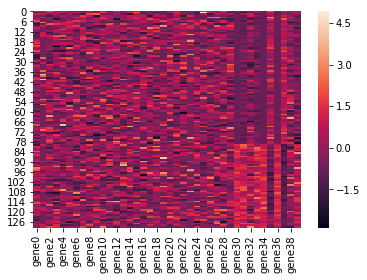

In [5]:
dgeScaled = (dge-dge.mean())/dge.std()
sns.heatmap(dgeScaled)

In [6]:
pca = PCA(n_components=20)
pca.fit(dge)
cpts = pd.DataFrame(pca.transform(dge))
x_axis = np.arange(1, pca.n_components_+1)
pca_scaled = PCA(n_components=20)
pca_scaled.fit(dgeScaled)
cpts_scaled = pd.DataFrame(pca.transform(dgeScaled))

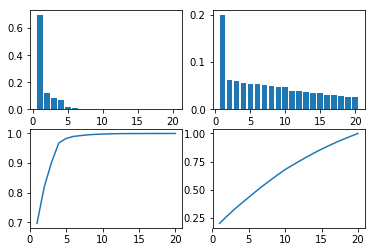

In [7]:
fig,ax = plt.subplots(2,2)
ax[0,0].bar(x_axis,pca.explained_variance_/pca.explained_variance_.sum())
ax[0,1].bar(x_axis,pca_scaled.explained_variance_/pca_scaled.explained_variance_.sum())
ax[1,0].plot(x_axis,pca.explained_variance_.cumsum()/pca.explained_variance_.sum())
ax[1,1].plot(x_axis,pca_scaled.explained_variance_.cumsum()/pca_scaled.explained_variance_.sum())

In [10]:
#split data into sets
X_train, X_test, y_train, y_test = train_test_split(dgeScaled,\
                                    labels,\
                                    test_size=0.1, stratify=labels, random_state=123456)

In [11]:
#train
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

Out-of-bag score estimate: 1.0
Mean accuracy score: 1.0


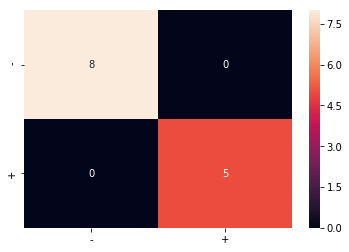

In [12]:
#predict
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

#plot confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['-','+'], index=['-','+'])
sns.heatmap(cm, annot=True)

In [13]:
#select top 200 most important genes as differentially expressed
diffExpGenesRF = pd.Series(rf.feature_importances_, index=['gene'+str(i) for i in range(0,numGenes+numDE)])
print(diffExpGenesRF.shape)
diffExpGenesRF = diffExpGenesRF.sort_values(ascending=False)[0:numDE].index
print(len(diffExpGenesRF))

(40,)
10


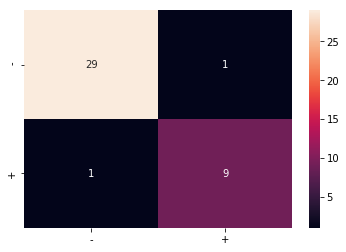

In [14]:
cm = pd.DataFrame(confusion_matrix([g in diffExpGenesRF for g in dge.keys()],\
                 [False for _ in range(0,numGenes)] + [True for _ in range(0,numDE)]),\
                 columns=['-','+'], index=['-','+'])
sns.heatmap(cm, annot=True)

In [39]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Out-of-bag score estimate: 1.0
Mean accuracy score: 1.0


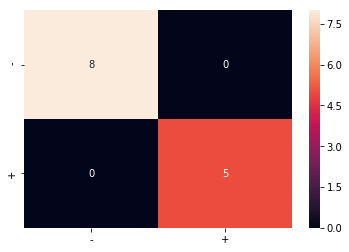

In [40]:
predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

#plot confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['-','+'], index=['-','+'])
sns.heatmap(cm, annot=True)

In [44]:
clf.coef_[0]
#select top 200 most important genes as differentially expressed
diffExpGenesRF = pd.Series(clf.coef_[0], index=['gene'+str(i) for i in range(0,numGenes+numDE)])
print(diffExpGenesRF.shape)
diffExpGenesRF = diffExpGenesRF.sort_values(ascending=False)[0:numDE].index
print(len(diffExpGenesRF))

(40,)
10


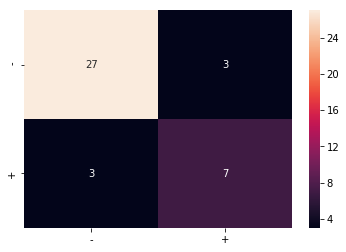

In [45]:
cm = pd.DataFrame(confusion_matrix([g in diffExpGenesRF for g in dge.keys()],\
                 [False for _ in range(0,numGenes)] + [True for _ in range(0,numDE)]),\
                 columns=['-','+'], index=['-','+'])
sns.heatmap(cm, annot=True)

In [182]:
#find differentially expressed genes
    
#logFC
meanGroup1 = np.log((np.exp(dge.loc[0:numCellsNeg])-1).mean()+1)
meanGroup2 = np.log((np.exp(dge.loc[numCellsNeg+1:])-1).mean()+1)
logFC = meanGroup1 - meanGroup2

#join them
diffExp = pd.concat([logFC], axis=1)
diffExp.columns = ['logFC']

pvalues = []
for g in dge.keys():
    statistic, pval = mannwhitneyu(dge[g].loc[0:numCellsNeg].tolist(),\
        dge[g].loc[numCellsNeg+1:].tolist(),\
             use_continuity = True, alternative = 'two-sided')
    pvalues.append(pval)
diffExp['pval'] = pd.Series(pvalues, index=dge.keys())


fig, ax = plt.subplots(figsize=[8,6])
ax.scatter(np.log2(diffExp.logFC),-np.log10(diffExp.pval))

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
